In [96]:
#!pip3 install vk_api

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm import tqdm
import time
from sklearn.cluster import KMeans

In [3]:
import vk_api

VK_PHONE_NUMBER = '+79652509720'
VK_PASSWORD = 'runk.perm9dwep2PLED'

vk_session = vk_api.VkApi(VK_PHONE_NUMBER, VK_PASSWORD)
vk_session.auth()

vk = vk_session.get_api()

# VK Parsing

In [4]:
def vk_friends_response(user_id=None):

    data = {}
    ids = []
    vk_fields = ['city', 'education', 'sex']
    try:
        response = vk.friends.get(user_id=user_id, count=5000, fields=vk_fields)['items']
    except vk_api.exceptions.ApiError:
        return [], {}

    for friend in response:
        fid = friend['id']
        ids.append(fid)
        data[fid] = {
            'first_name' : friend.get('first_name', ''),
            'last_name' : friend.get('last_name', ''),
            'sex' : friend.get('sex', None),
            'city' : friend.get('city', {}).get('title', ''),
            'university_name' : friend.get('university_name', ''),
            'is_closed' : friend.get('is_closed', ''),
        }

    edgelist = [(i, user_id) for i in ids]

    return edgelist, data

In [5]:
my_id = vk.users.get()[0]['id']

In [6]:
current_edgelist, current_data = vk_friends_response(user_id=my_id) # parse all my friends
full_edgelist, full_data = current_edgelist.copy(), current_data.copy()

parsed_ids = list(current_data.keys())
start_ids = list(current_data.keys())

In [7]:
counter = 0

for id in tqdm(start_ids): # parse friends of each of my friends
    current_edgelist, current_data = vk_friends_response(user_id=id)
    parsed_ids += list(current_data.keys())

    full_edgelist += current_edgelist
    full_data.update(current_data)

    counter+= 1

    if counter % 20 == 0:
        time.sleep(2)

    

100%|██████████| 137/137 [02:02<00:00,  1.12it/s]


In [8]:
G = nx.from_edgelist(full_edgelist)

my_neighbors = list(nx.all_neighbors(G, my_id)) # leave only my friends and connections between them
G = G.subgraph(my_neighbors)
nx.set_node_attributes(G, full_data)

In [ ]:
biggest_cc = sorted(nx.connected_components(G), key=lambda x: -len(x))[0]
G = G.subgraph(biggest_cc) # keep the biggest connected component

In [231]:
def pretty_graph_plot(
        G,
        filename,
        node_size=200,
        labels_which='top_node_50',
        edge_width=1,
        node_color='#FF1FE0',
        edge_color='#DDF730',
        cmap=plt.cm.viridis,
        draw_labels=False,
        draw_legend=False
):
        fig, ax = plt.subplots(figsize=(20, 20))

        if type(node_size) != int:
                node_size_list = np.array([j for i, j in node_size.items()])
                node_size_norm = (node_size_list - np.min(node_size_list)) / (np.max(node_size_list) - np.min(node_size_list))
                node_size_norm = 100 + node_size_norm * 500
        else:
                node_size_norm = 100

        if type(node_color) != str:
                node_color_ = np.array([j for i, j in node_color.items()])
        else:
                node_color_ = node_color

        labels = nx.get_node_attributes(G, 'last_name').items()
        n = int(labels_which.split('_')[-1])
        label_options = {"ec": "k", "fc": "white", "alpha": 0.7}

        if 'top_node' in labels_which:
                high_degree_nodes = [i for i, j in sorted(node_size.items(), key=lambda x: -x[1])[:n]]
                node_labels = {i: j for i, j in labels if i in high_degree_nodes}
        elif 'random' in labels_which:
                high_degree_nodes = np.random.choice(G.nodes, size=n, replace=False)
                node_labels = {i: j for i, j in labels if i in high_degree_nodes}

        pos = nx.kamada_kawai_layout(G)

        nx.draw_networkx_edges(G, pos, alpha=0.9, width=edge_width, edge_color=edge_color)
        nx.draw_networkx_nodes(G, pos, node_size=node_size_norm, node_color=node_color_, alpha=0.9, edgecolors='k', cmap=cmap)

        if draw_labels:
                nx.draw_networkx_labels(G, pos, node_labels, font_size=14, bbox=label_options)
                label_options = {"ec": "k", "fc": "white", "alpha": 0.7}


        if draw_legend:
                font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 21}
                font["color"] = "lightseagreen"

                ax.text(
                0.80,
                0.08,
                "edge width = NOTHING",
                horizontalalignment="center",
                transform=ax.transAxes,
                fontdict=font,
                )
                ax.text(
                0.80,
                0.06,
                "node size = NOTHING",
                horizontalalignment="center",
                transform=ax.transAxes,
                fontdict=font,
                )

        # Resize figure for label readability
        ax.margins(0.1, 0.05)
        fig.tight_layout()
        plt.axis("off")
        plt.show()

        fig.savefig(filename+'.png', dpi=150)

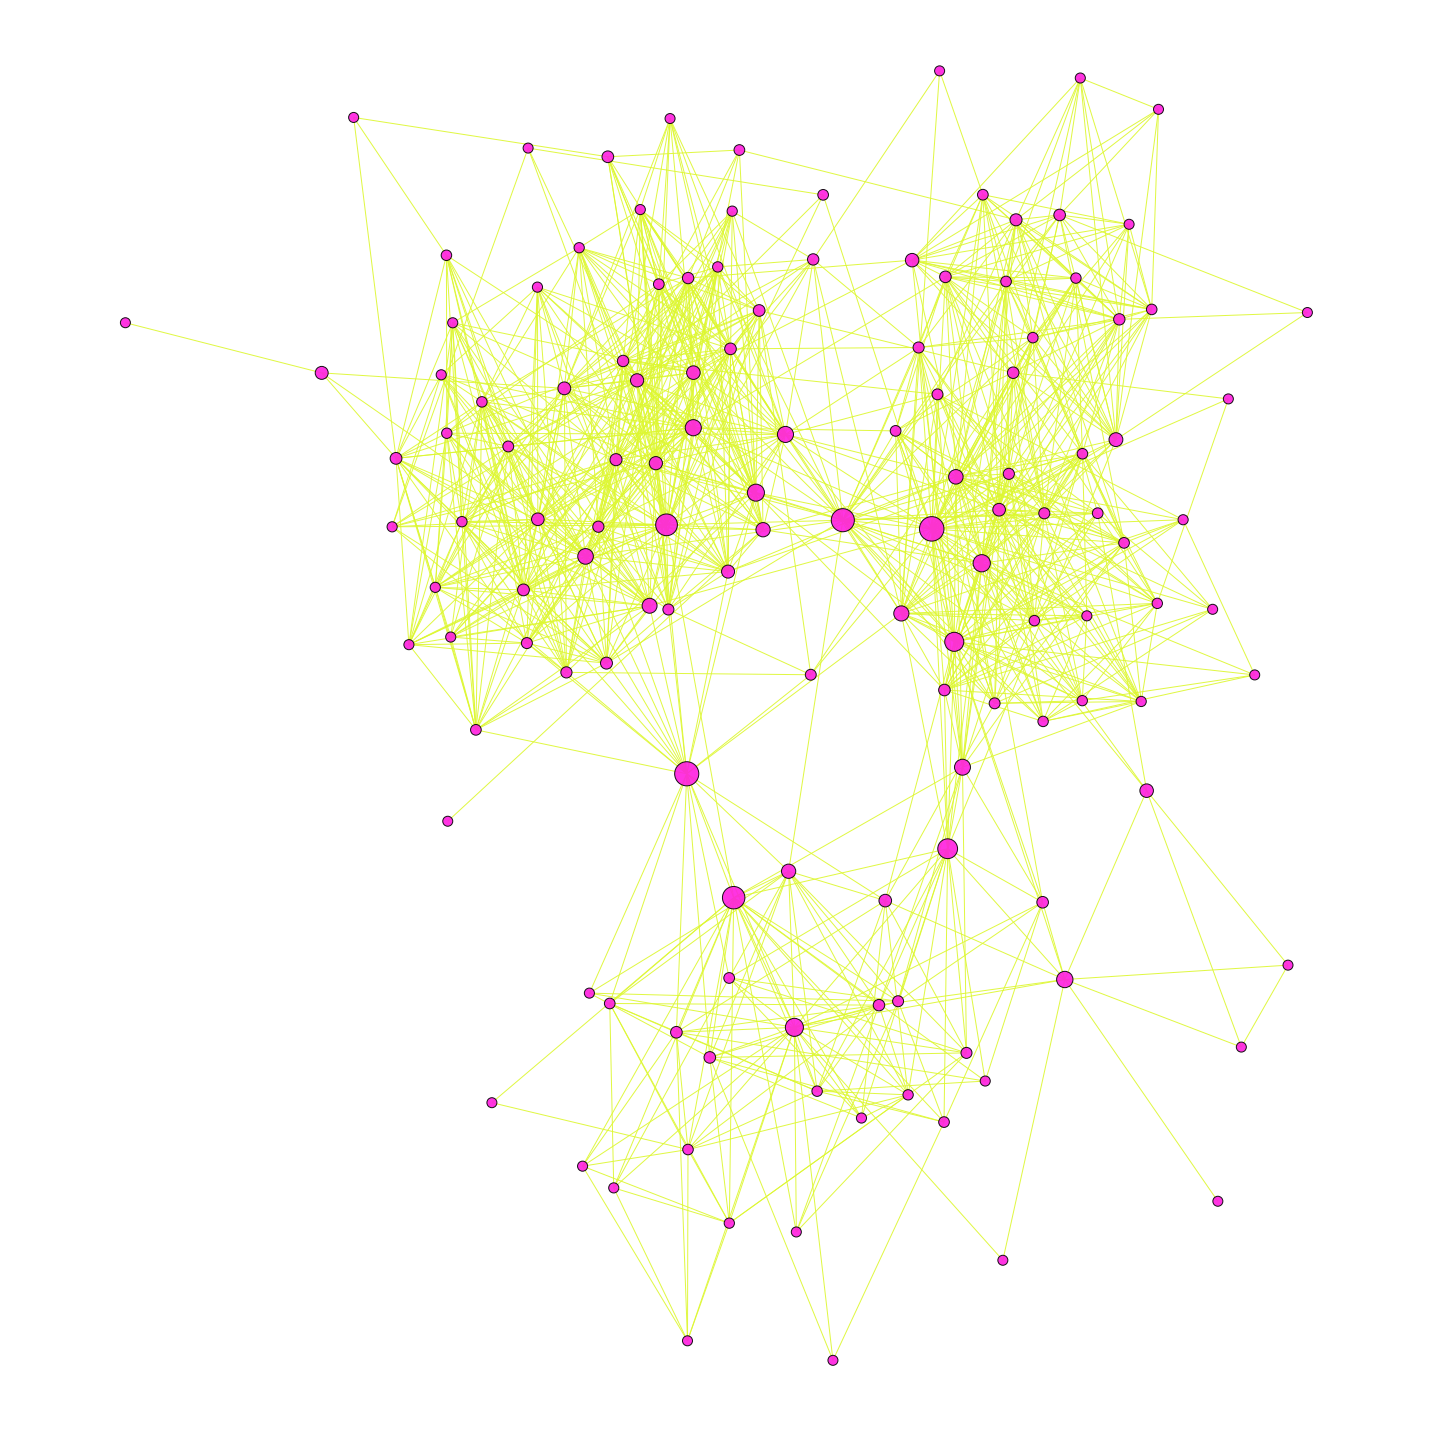

In [119]:
pretty_graph_plot(G, filename='Title', node_size=nx.betweenness_centrality(G), labels_which='top_node_50')

In [15]:
#nx.write_gml(G, "vk_friends.gml")

# Network summary

- The graph is undirected, edges represent friendship connections between VK users.
- Each node has multiple attributes:
  - `first_name`;
  - `last_name`;
  - `sex` (1 for female, 2 for male);
  - `city` ();
  - `university_name` ();
  - `is_closed` (boolean flag: if the account is available to the public).
- **Diameter** = 6
  - Diameter is maximum eccentricity, which is the maximum distance from a node to all other nodes in the graph.
- **Radius** = 3
  - Radius is minimum eccentricity.
- **Average clustering coefficient** = 0.555
  - Clustering coefficient of a node $u$ is the fraction of possible triangles through that node that actually exist, $$C(u) = \frac{2 T(u)}{deg(u)(deg(u)-1)},$$ where $T(u)$ is the number of triangles through node $u$ and $deg(u)$ is the degree of $u$.
- **Average shortest path length** = 2.5

In [16]:
G.nodes.data()[70209042] # Example of a node

{'first_name': 'Настя',
 'last_name': 'Купцова',
 'sex': 1,
 'city': '',
 'university_name': 'НИУ ВШЭ (ГУ-ВШЭ)',
 'is_closed': False}

In [17]:
# Graph metrics

for func in [
    nx.diameter,
    nx.radius,
    nx.average_clustering,
    nx.average_shortest_path_length
]:
    title = ' '.join(func.__name__.split('_')).capitalize()
    result = np.round(func(G), 3)
    print(title + ':' + ' ' + str(result))

Diameter: 6
Radius: 3
Average clustering: 0.555
Average shortest path length: 2.531


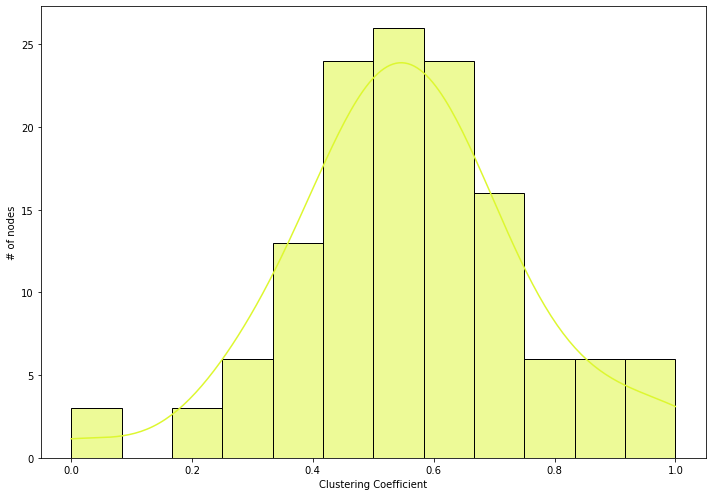

In [148]:
clustering_coefs = [j for i, j in nx.clustering(G).items()]

fig, ax = plt.subplots(1, figsize=(10, 7))
sns.histplot(
    clustering_coefs,
    ax=ax,
    color='#DDF730',
    alpha=0.5,
    kde=True,
    kde_kws={'bw_adjust': 1.3}
    )

ax.set(xlabel='Clustering Coefficient', ylabel='# of nodes')

plt.tight_layout()
plt.show()
fig.savefig('clustering_coefficient.png', dpi=150, transparent=True)

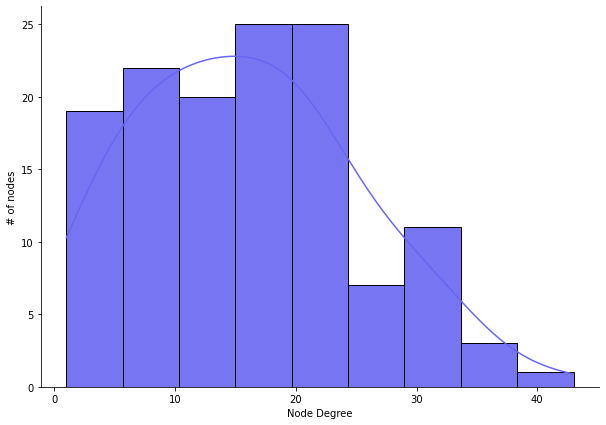

In [145]:
node_degrees = [j for i, j in list(G.degree)]

fig, ax = plt.subplots(1, figsize=(10, 7))
sns.histplot(
    node_degrees,
    ax=ax,
    color='#6966F2',
    alpha=0.9,
    kde=True,
    kde_kws={'bw_adjust': 1.3}
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set(xlabel='Node Degree', ylabel='# of nodes')

plt.tight_layout()
plt.show()
fig.savefig('node_degree.png', dpi=150, transparent=True)

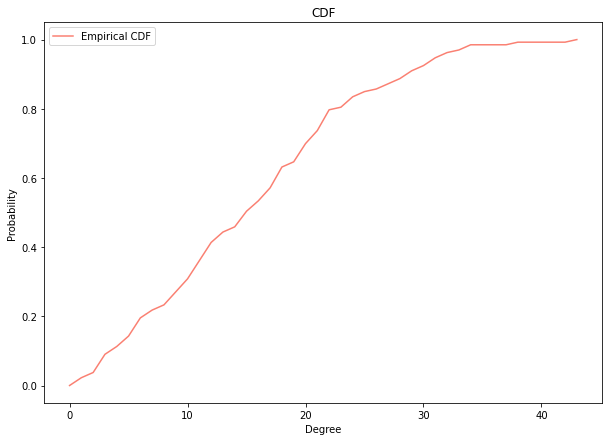

In [151]:
def empirical_cdf(g):
    h = nx.degree_histogram(g)
    return np.cumsum(h) / np.sum(h)

ecdf = empirical_cdf(G)

fig, ax = plt.subplots(1, figsize=(10, 7))

ax.plot(ecdf, color='salmon', label='Empirical CDF')
ax.set(title='CDF', xlabel='Degree', ylabel='Probability')
ax.legend()

plt.show()

# Node Degree Modelling

In [174]:
from scipy.stats import poisson

def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

def power_law_cdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return 1 + C / (1 - alpha) * x ** (1 - alpha)

def power_law_ppf(r, alpha=3.5, x_min=1):
    return (1 - r) ** (1 / (1 - alpha)) * x_min

def power_law_generate(n, alpha=3.5, x_min=1, random_seed=1):
    np.random.seed(random_seed)
    uni_sample = np.random.uniform(0, 0.999, n)
    return power_law_ppf(uni_sample, alpha, x_min)

def poisson_cdf(x, lambda_):
    return poisson.cdf(x, lambda_)

In [175]:
from scipy.stats import kstest

def mle_power_law_params(degree_sequence, x_min_range=None):
    ks_stats = []
    alphas = []

    if x_min_range is None:
        x_min_range = np.arange(np.floor(np.min(degree_sequence)), np.ceil(np.max(degree_sequence)))

    for x_min_select in x_min_range:
        x_select = degree_sequence[degree_sequence>=x_min_select]

        if len(x_select) > 2:
            alpha_select = 1 + len(x_select) * (np.sum(np.log(x_select/x_min_select))) ** (-1)
            alphas.append(alpha_select)

            kst = kstest(x_select, lambda x: power_law_cdf(x, alpha=alpha_select, x_min=x_min_select)).statistic
            ks_stats.append(kst)

    idx = np.argmin(ks_stats)
    x_min_hat = x_min_range[idx]
    alpha_hat = alphas[idx]

    return alpha_hat, x_min_hat


def mle_poisson_params(degree_sequence):
    lambda_hat = np.mean(degree_sequence)
    return lambda_hat

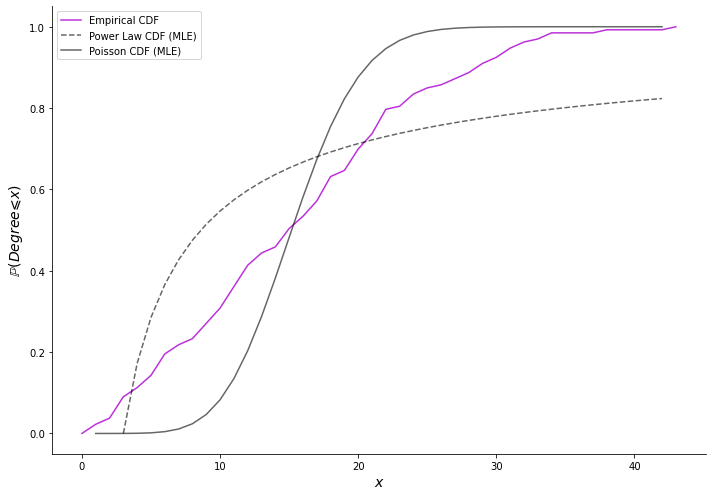

In [187]:
degree_sequence = np.array(node_degrees)

x_min_range = [1, 2, 3]
hat_alpha, hat_x_min = mle_power_law_params(degree_sequence, x_min_range=x_min_range)
x_space_1 = np.arange(hat_x_min, degree_sequence.max(), 1)
power_cdf = power_law_cdf(x_space_1, alpha=hat_alpha, x_min=hat_x_min)

x_min_range = [1, 2, 3]
hat_lambda = mle_poisson_params(degree_sequence)
x_space_2 = np.arange(1, degree_sequence.max(), 1)
pois_cdf = poisson_cdf(x_space_2, lambda_=hat_lambda)

fig, ax = plt.subplots(1, figsize=(10, 7))

ax.plot(ecdf, color='#BB30DA', label='Empirical CDF')
ax.plot(x_space_1, power_cdf, 'k--', alpha=0.6, label='Power Law CDF (MLE)')
ax.plot(x_space_2, pois_cdf, color='k', alpha=0.6, label='Poisson CDF (MLE)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

ax.set(xlabel='$x$', ylabel='$\mathbb{P}(Degree\leqslant x)$')
ax.legend()

plt.tight_layout()
plt.show()
fig.savefig('CDF.png', dpi=150, transparent=True)

# Random Models

In [227]:
def estimate_ER(G):
    n = len(G.nodes)
    N = n * (n-1) / 2
    p = len(G.edges) / N
    
    return n, p

def estimate_WS(G):
    n = len(G.nodes)
    k = int(np.mean([j for i, j in list(G.degree)]))
    p = 0.5
    
    return n, k, p

ER = nx.erdos_renyi_graph(*estimate_ER(G))
BA = nx.barabasi_albert_graph(len(G.nodes), 2)
WS = nx.watts_strogatz_graph(*estimate_WS(G))

In [228]:
for func in [
    nx.diameter,
    nx.radius,
    nx.average_clustering,
    nx.average_shortest_path_length
]:
    title = ' '.join(func.__name__.split('_')).capitalize()
    results = (
        ('Empirical', np.round(func(G), 3)),
        ('Erdős–Rényi', np.round(func(ER), 3)),
        ('Barabási–Albert', np.round(func(BA), 3)),
        ('Watts–Strogatz', np.round(func(WS), 3)),
               )
    print(title)
    for model_name, metric in results:
        print(f'\t{model_name}: {metric}')

Diameter
	Empirical: 6
	Erdős–Rényi: 3
	Barabási–Albert: 6
	Watts–Strogatz: 3
Radius
	Empirical: 3
	Erdős–Rényi: 3
	Barabási–Albert: 3
	Watts–Strogatz: 3
Average clustering
	Empirical: 0.555
	Erdős–Rényi: 0.124
	Barabási–Albert: 0.067
	Watts–Strogatz: 0.154
Average shortest path length
	Empirical: 2.531
	Erdős–Rényi: 1.987
	Barabási–Albert: 3.275
	Watts–Strogatz: 2.126


# Centralities

In [234]:
def centralities(G: nx.Graph):

    d = nx.degree_centrality(G)
    c = nx.closeness_centrality(G)
    b = nx.betweenness_centrality(G)

    return {
        'degree': d,
        'closeness': c,
        'betweenness': b
    }

def top10_centralities(G: nx.Graph):
    graph_centralities = centralities(G)
    top_10 = {}

    base_df = pd.DataFrame(
        [
            (v['first_name'], v['last_name']) for k,v in G.nodes.data()],
        columns=['first_name', 'last_name']
        )
    
    for c_name, c_values in graph_centralities.items():
        c_df = base_df.copy()
        c_values_ = np.array([j for i, j in c_values.items()])
        c_df['centrality'] = c_values_
        c_df.sort_values('centrality', ascending=False, inplace=True)
        c_df = c_df.head(10)
        c_df['centrality'] = np.round(c_df['centrality'], 3)

        top_10[c_name] = c_df

    return top_10

c = centralities(G)
top_dfs = top10_centralities(G)

Degree centrality


first_name     last_name  centrality
13         Фил       Смирнов       0.326
123     Максим        Пешков       0.288
68       Игорь    Колесников       0.258
60       Света  Масленникова       0.258
7        Елена   Смысловских       0.250
106      Борис      Карпычев       0.242
67       Артем     Татаринов       0.242
117       Таня      Бакирова       0.235
93        Саша     Романенко       0.235
32       Мария       Силкина       0.235

<Figure size 720x576 with 0 Axes>

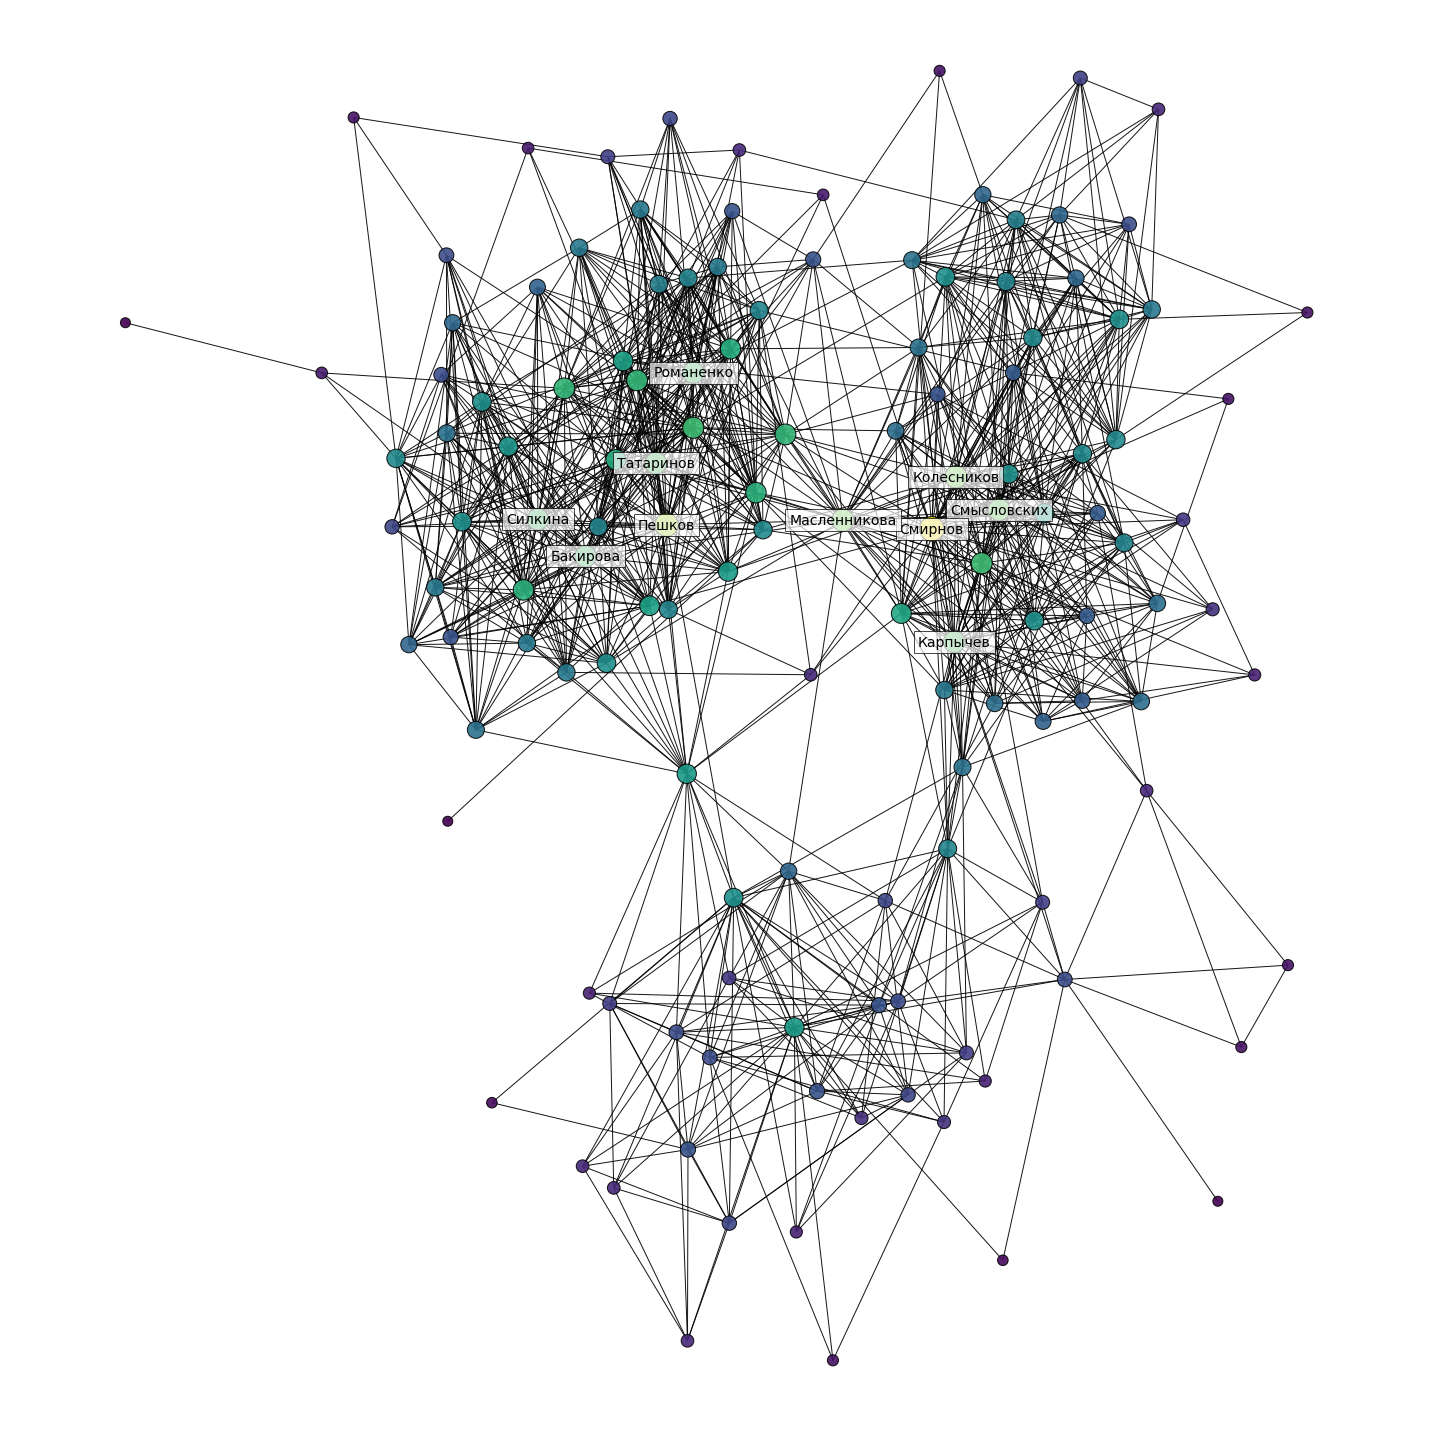

Closeness centrality


first_name     last_name  centrality
13         Фил       Смирнов       0.548
60       Света  Масленникова       0.532
123     Максим        Пешков       0.510
16     Алексей       Забелин       0.506
106      Борис      Карпычев       0.500
40    Angelika   Zagashvilli       0.493
109    Дмитрий        Мячков       0.489
74        Миша     Майданчик       0.485
4        Света       Шаповал       0.484
55       Арина     Соловьева       0.482

<Figure size 720x576 with 0 Axes>

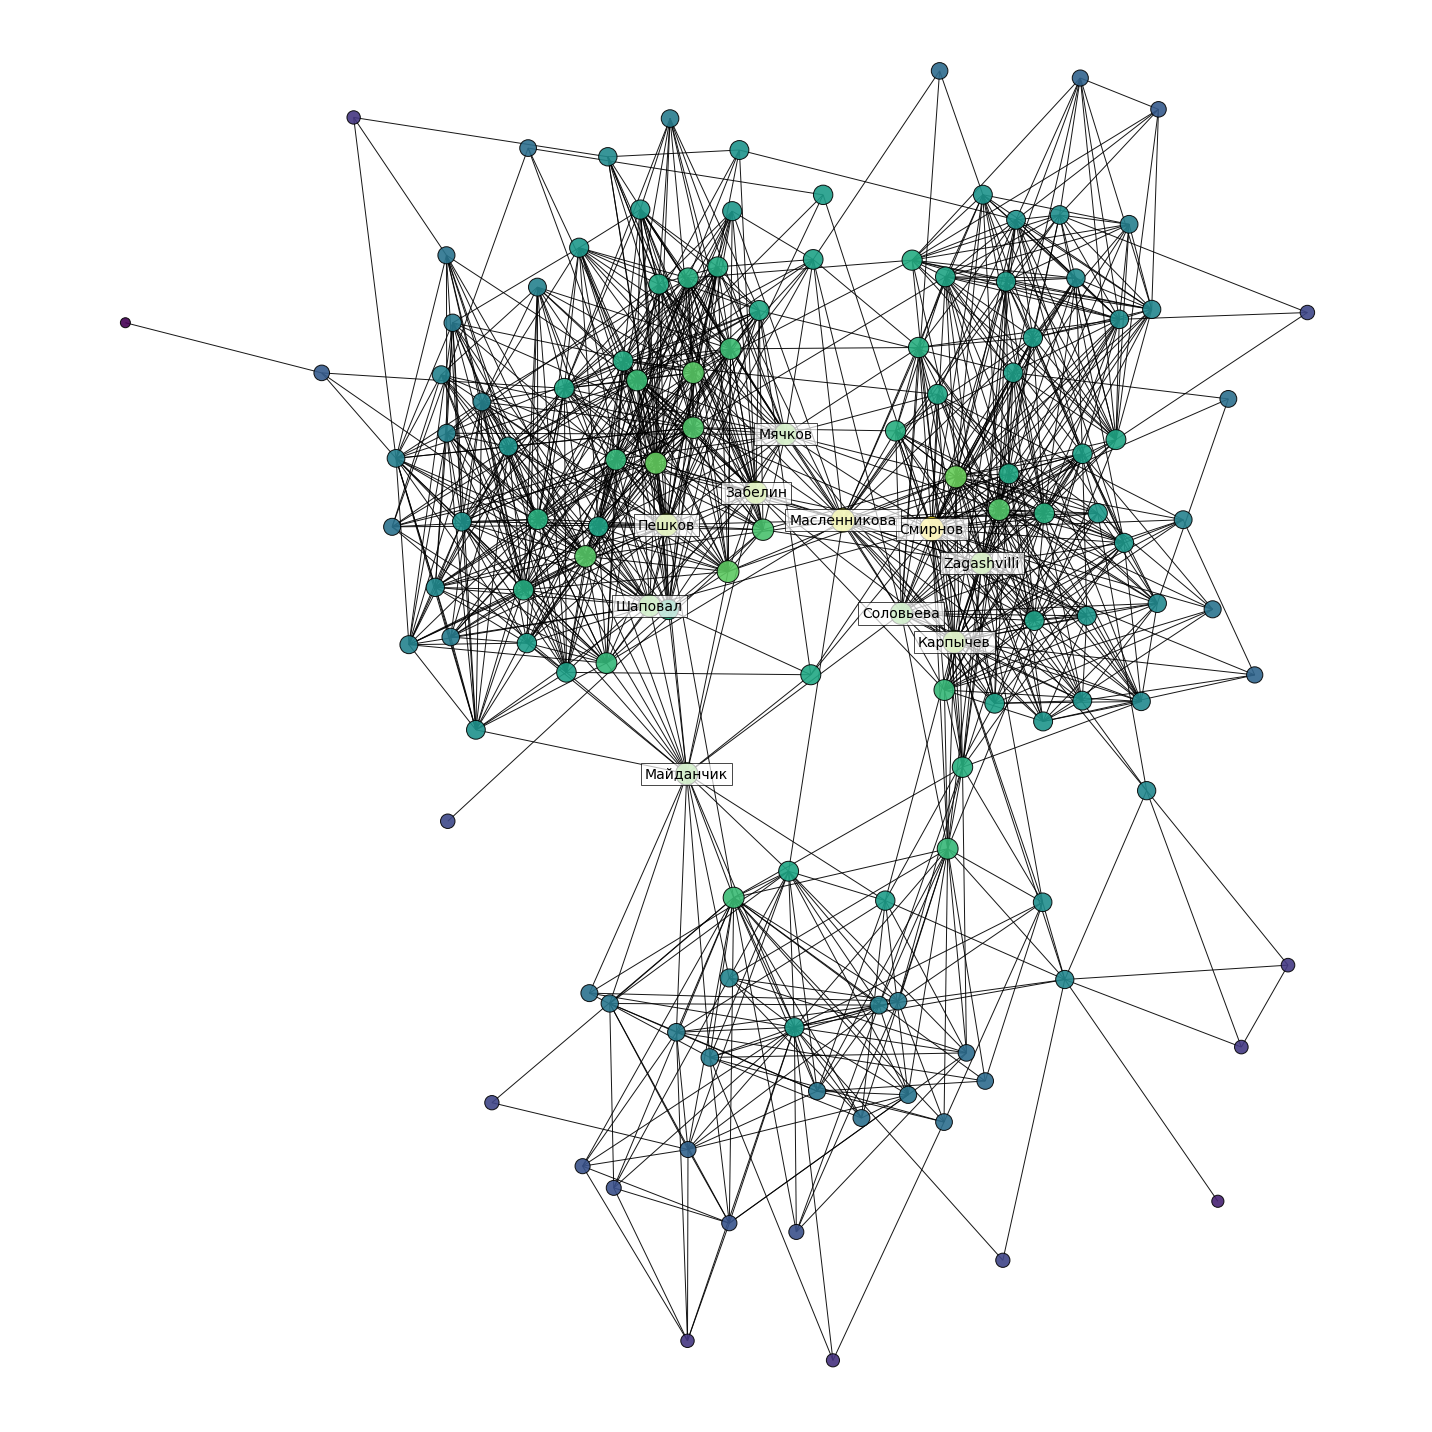

Betweenness centrality


first_name     last_name  centrality
13         Фил       Смирнов       0.112
74        Миша     Майданчик       0.108
60       Света  Масленникова       0.097
14      Андрей   Колесницкий       0.090
123     Максим        Пешков       0.083
127  Екатерина      Латухина       0.065
106      Борис      Карпычев       0.059
124    Варвара       Дивеева       0.051
40    Angelika   Zagashvilli       0.044
16     Алексей       Забелин       0.042

<Figure size 720x576 with 0 Axes>

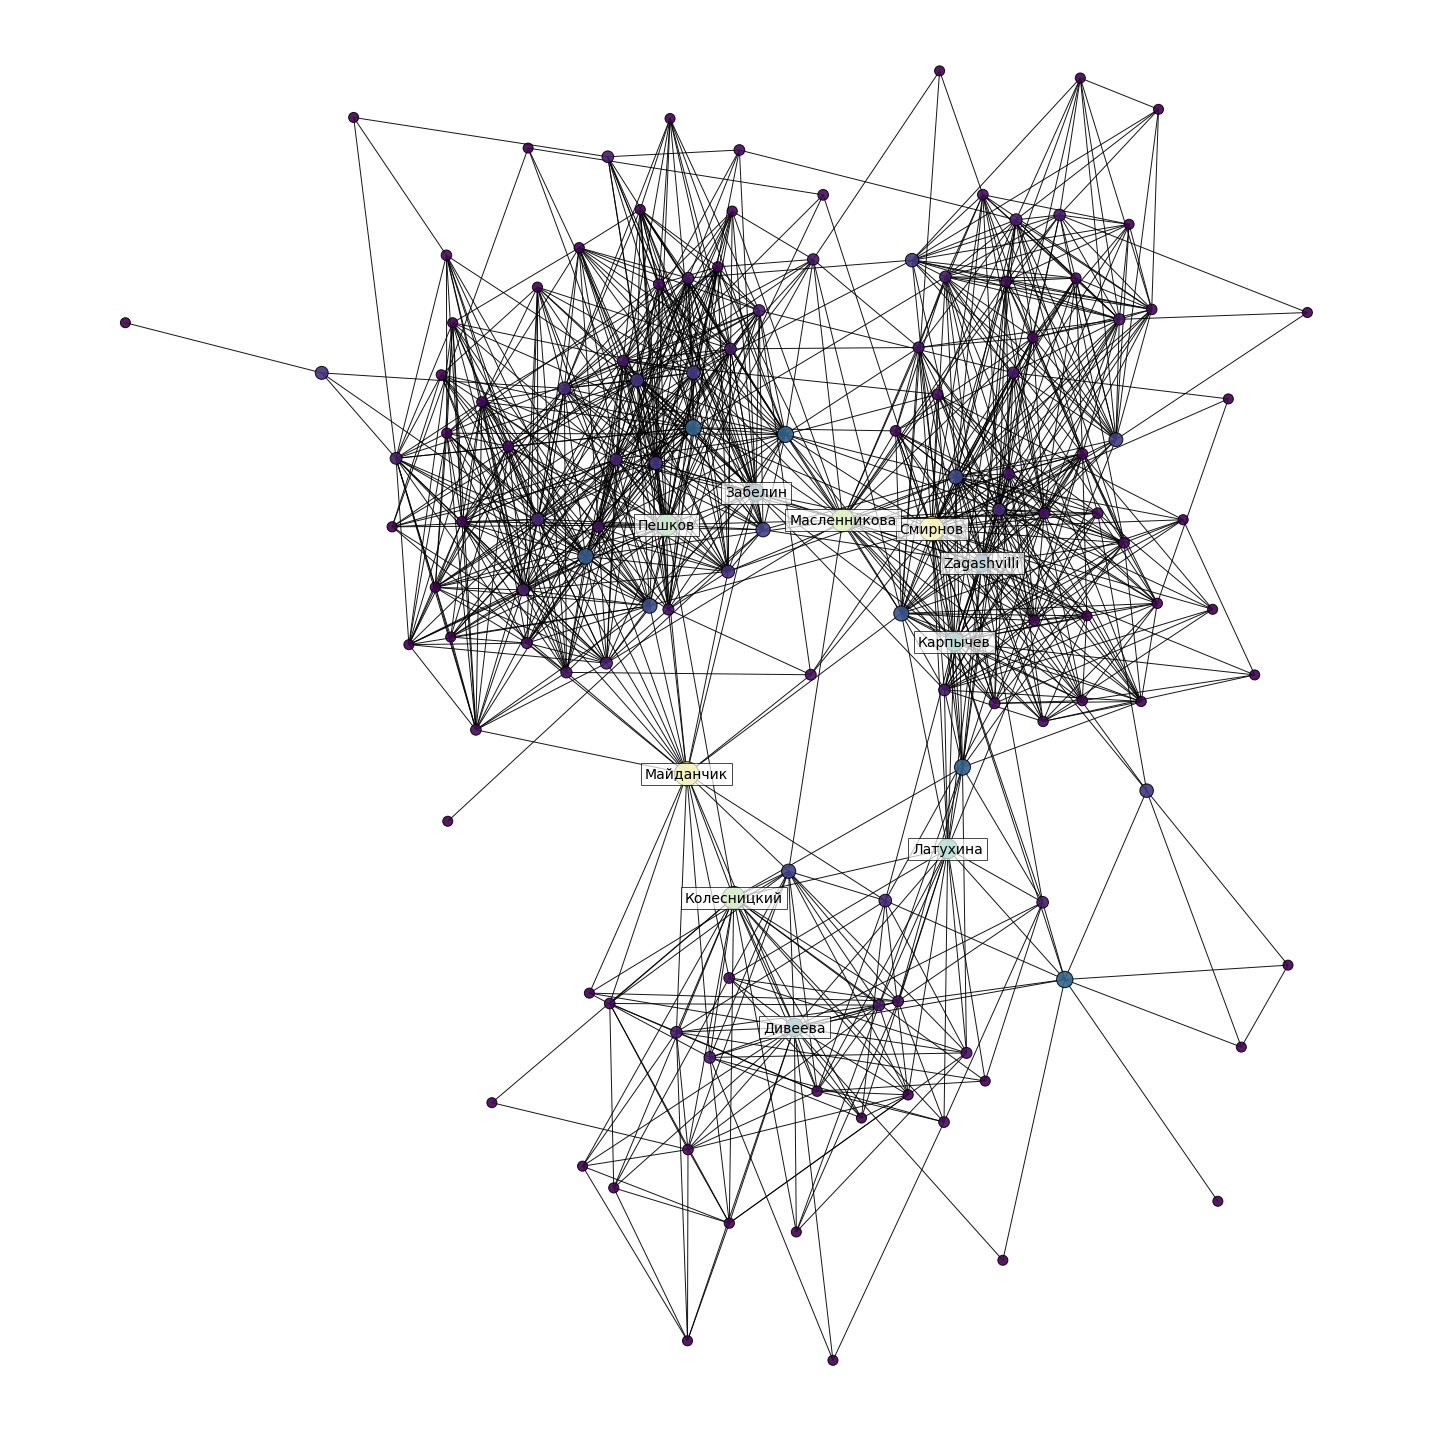

In [235]:
cases = [['degree', 1000, 0, 'Degree centrality'], 
         ['closeness', 1000, 0, 'Closeness centrality'], 
         ['betweenness', 10000, 100, 'Betweenness centrality']]

pos = nx.kamada_kawai_layout(G)

for c_key, scale, bias, title in cases:
    print(title)
    display(top_dfs[c_key])
    plt.figure(figsize=(10, 8))
    pretty_graph_plot(G, filename=c_key, node_size=c[c_key], node_color=c[c_key], edge_color='k', labels_which='top_node_10', draw_labels=True)

In [236]:
def katz_centrality(G: nx.Graph, n: int, beta: float) -> np.array:
    A = nx.adjacency_matrix(G).toarray()
    idx_conversion = {j: i for i, j in enumerate(G.nodes)}
    
    beta_threshold = 1 / np.max(np.linalg.eigvals(A))
    if beta >= beta_threshold:
        raise ValueError(f"Beta ({beta}) is greater than {np.round(beta_threshold, 3)}!")
    
    katz = np.zeros(A.shape[0])
    for n_ in range(1, n+1):
        katz_iter = beta**n_ * np.linalg.matrix_power(A, n_).sum(axis=1)
        katz += katz_iter

    return katz

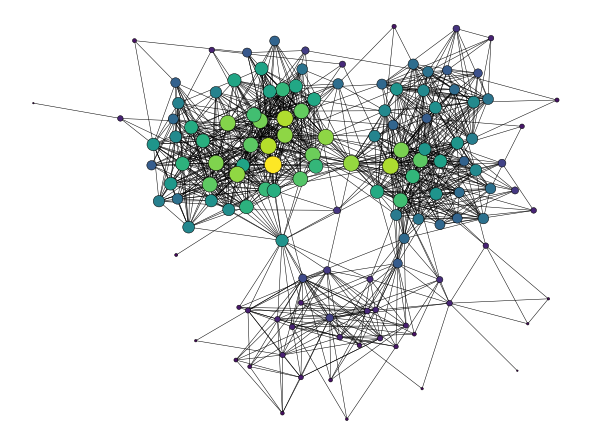

In [212]:
katz_c = katz_centrality(G, 20, 0.04)
katz_c = katz_c / katz_c.max()

plt.figure(figsize=(8, 6))
nx.draw(G, 
        pos,
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.viridis,
        node_size=katz_c*300,
        node_color=katz_c)
plt.show()

In [213]:
def eigenvector_centrality(A: np.array) -> np.array:
    """
    Calculate eigenvector centrality
    
    :param A: adjacency matric of graph
    :return: array of eigenvector centralities
    """
    
    l, V = np.linalg.eig(A)
    max_l = np.argmax(l)
    return np.abs(V[:,max_l])

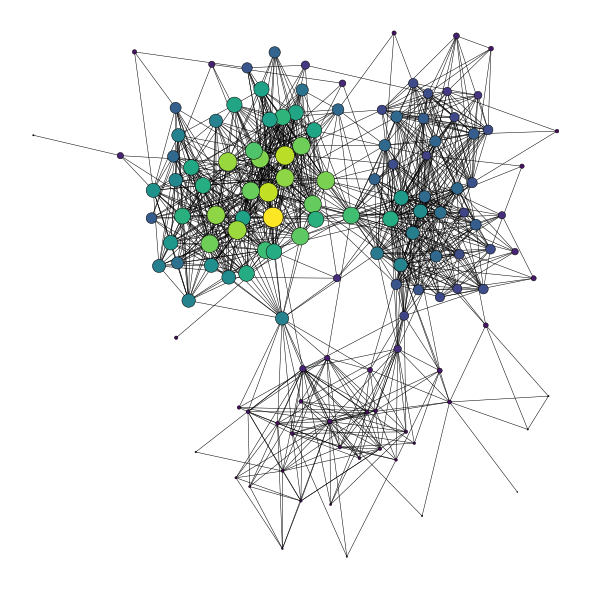

In [239]:
eig_c = eigenvector_centrality(nx.to_numpy_array(G))

plt.figure(figsize=(8, 8))
nx.draw(G, 
        pos,
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.viridis,
        node_size=eig_c/eig_c.max()*400,
        node_color=eig_c)
plt.savefig('eigenvector_centrality.png', transparent=True, dpi=150)

In [215]:
def pearson_correlation(i_vals: np.array, j_vals: np.array) -> float:
    """
    Calculate Pearson correlation coefficient
    
    :param i_vals: array of centralities
    :param j_vals: array of centralities
    :return: Pearson's correlation
    """
    
    return np.corrcoef(i_vals, j_vals)[0,1]

In [216]:
centvals = [
    ('Degree', list(nx.degree_centrality(G).values())),
    ('Closeness', list(nx.closeness_centrality(G).values())),
    ('Betweenness', list(nx.betweenness_centrality(G).values())),
    ('Katz', katz_centrality(G, 30, 0.04)), 
    ('Eigenvector', eigenvector_centrality(nx.to_numpy_array(G)))
]

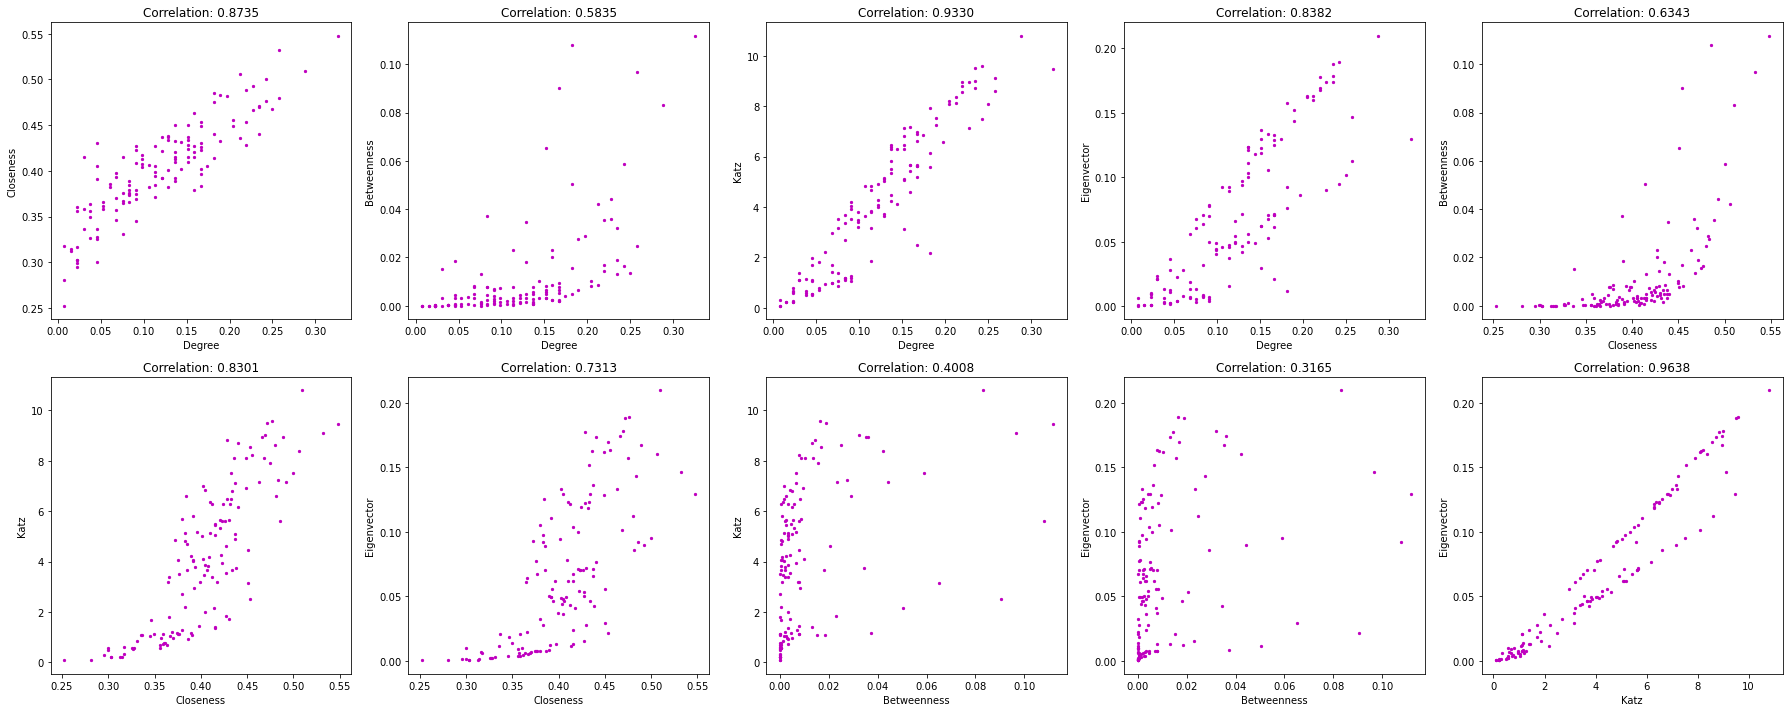

In [225]:
plt.figure(figsize=(5*5, 2*5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
k = 1
for i in range(len(centvals)):
    for j in range(i + 1, len(centvals)):
        i_label, i_vals = centvals[i]
        j_label, j_vals = centvals[j]
        correlation = pearson_correlation(i_vals, j_vals)
        plt.subplot(2, 5, k)
        plt.scatter(i_vals, j_vals, s=5, c='m')
        plt.title('Correlation: {:.4f}'.format(correlation))
        plt.xlabel(i_label)
        plt.ylabel(j_label)
        k += 1

plt.tight_layout()
#plt.show()
plt.savefig('centrality_correlation.png', dpi=150, transparent=True)

# Communities

## Cliques

In [90]:
def largest_cliques(G):
    cliques = list(nx.find_cliques(G))
    clique_sizes = [len(i) for i in cliques]
    max_clique_size = np.max(clique_sizes)

    cliques = np.array([c for c in cliques if len(c)==max_clique_size])
    nodes = np.array(list(G.nodes))

    clique_mask = (nodes==cliques[...,None]).any(axis=1)

    n = clique_mask.shape[0]
    m = clique_mask.shape[1]

    w = np.array([[[1,1,1]]*m]*n)
    c = np.array([[[0.5,0.1,0.1]]*m]*n)

    colors = np.where(clique_mask[:,:,np.newaxis], (c), (w))

    widths = []
    for clique in cliques:

        widths_ = [2 if (i in clique and j in clique) else 0.5 for i, j in G.edges]
        widths.append(widths_)
    widths = np.array(widths)
    
    return colors, widths

colors, widths = largest_cliques(G)
size = np.unique(colors[0], axis=0, return_counts=True)[1][0]

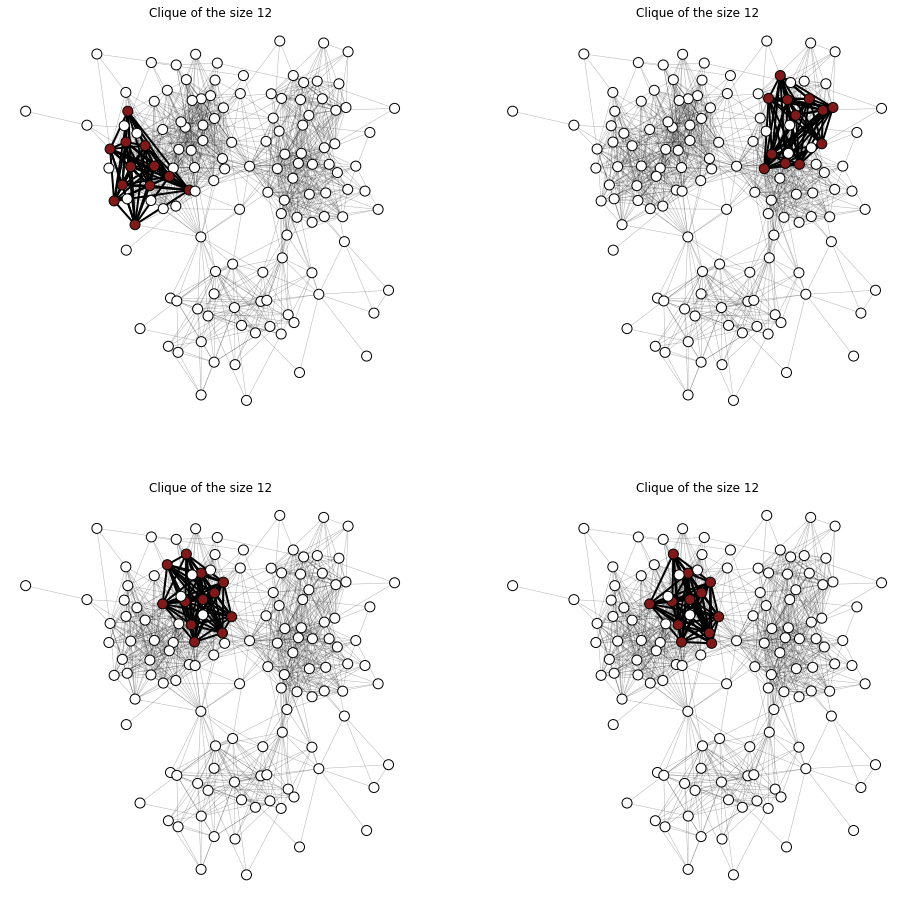

In [95]:
plt.figure(figsize=(16, 16))

for i in range(colors.shape[0]):
    
    b_edges = np.array(list(G.edges))[widths[i] == widths[i].max()]
    
    plt.subplot(2, 2, i+1)
    nodes = nx.draw_networkx_nodes(
        G, 
        pos,
        node_color=colors[i], 
        node_size=100, 
        linewidths=1, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        G,
        pos,
        alpha=0.3,
        width=widths[i].min()
    )
    nx.draw_networkx_edges(
        G,
        pos,
        width=widths[i].max(),
        edgelist=b_edges
    )
    plt.title('Clique of the size {}'.format(size))
    plt.axis('off')

## Laplacian & K-Means

In [97]:
def norm_laplacian(A):
    d = np.sum(A, axis=0)
    D = np.diag(d)
    D2 = np.diag(d**(-1/2))
    return D2 @ (D - A) @ D2

A = nx.to_numpy_array(G)
L = norm_laplacian(A)

def spectral_embedding(L, n_components):
    vals, vecs = np.linalg.eigh(L)
    vecs = np.array(vecs)
    vecs = vecs[:, 1:n_components+1]

    return vecs

embedding = spectral_embedding(L, 3)

def spectral_clustering(G, n_clusters, n_components):
    A = nx.to_numpy_array(G)
    L = norm_laplacian(A)
    embedding = spectral_embedding(L, n_components)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    return kmeans.labels_

embedding = spectral_embedding(L, 3)
labels = spectral_clustering(G, 3, 3)

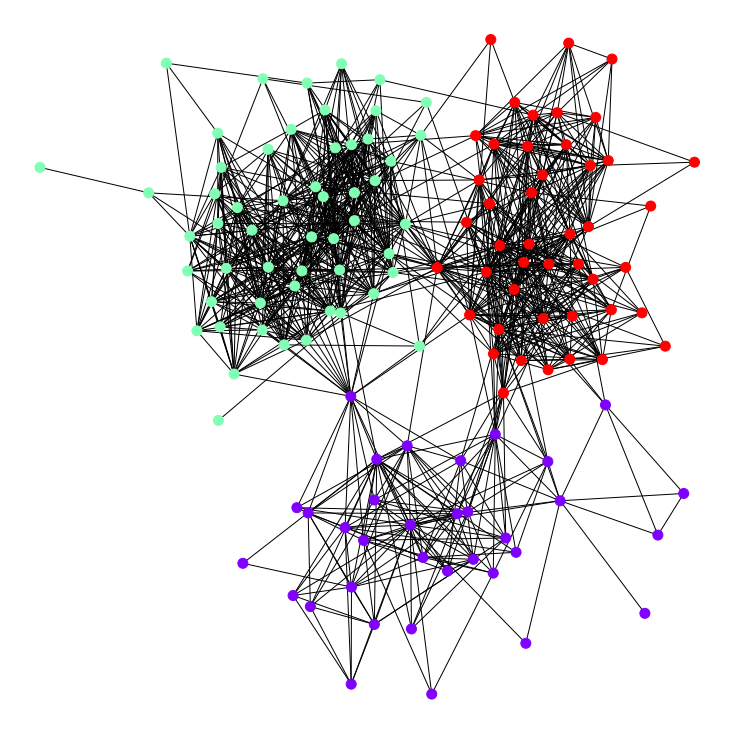

In [226]:
plt.figure(figsize=(10, 10))
nx.draw_kamada_kawai(
    G,
    cmap=plt.cm.rainbow,
    node_color=labels, 
    edgecolors=None, 
    node_size=100)

plt.savefig('k_means.png', dpi=150, transparent=True)

# Assortative mixing

In [320]:
uni_dict = nx.get_node_attributes(G, 'university_name')
u, c = np.unique(list(uni_dict.values()), return_counts=True)
multiple_counts = u[c>=2]
uni_dict = {i: j if j in multiple_counts else 'Other' for i, j in uni_dict.items()}
uni_dict = {i: j if j != '' else 'Undefined' for i, j in uni_dict.items()}

uni_values = {
    'Undefined': 0,
    'Other': 1,
    'НИУ ВШЭ (ГУ-ВШЭ)': 2,
    'РГГУ': 3,
    'МГИМО МИД России': 4,
    'МГУ': 5
}
uni_values_nou = {
    'Other': 0,
    'НИУ ВШЭ (ГУ-ВШЭ)': 1,
    'РГГУ': 2,
    'МГИМО МИД России': 3,
    'МГУ': 4
}


uni_dict_mapping = {i: uni_values[j] for i, j in uni_dict.items()}

In [317]:
nx.set_node_attributes(G, uni_dict_mapping, name='uni_code')
nx.set_node_attributes(G, uni_dict, name='uni_clean')

In [318]:
def assortativity_coef(mixing):
    trE = np.trace(mixing)
    E2 = np.sum(np.linalg.matrix_power(mixing, 2))
    r = (trE - E2) / (1 - E2)

    return r

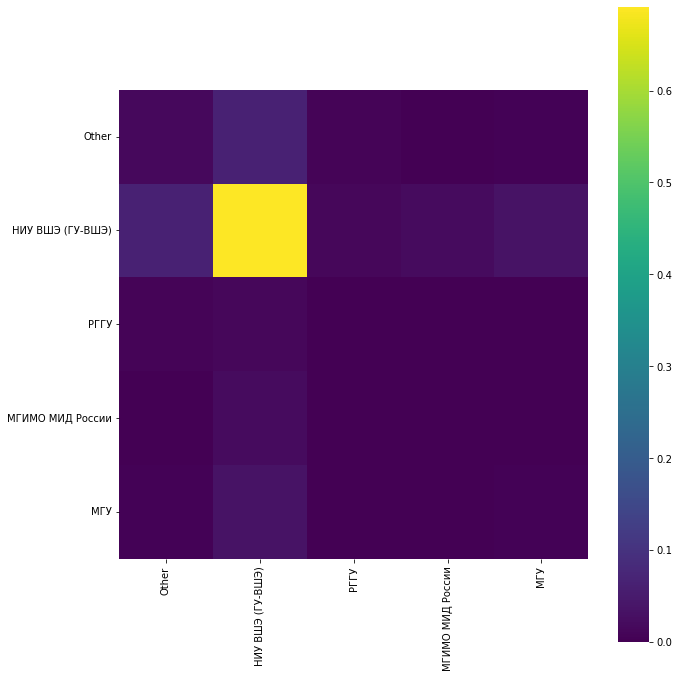

In [325]:
nodes_with_uni=[i for i, j in nx.get_node_attributes(G, 'uni_clean').items() if j!='Undefined']
G_subset = G.subgraph(nodes_with_uni)
AM_uni = nx.attribute_mixing_matrix(G_subset, 'uni_clean', mapping=uni_values_nou)

fig = plt.figure(figsize=(10, 10))
hmap = sns.heatmap(
    AM_uni,
    cbar=True,
    cmap='viridis',
    square=True)
hmap.set_xticklabels([m for m in uni_values_nou], rotation=90)
hmap.set_yticklabels([m for m in uni_values_nou], rotation=0)
plt.tight_layout()
plt.savefig('AM_uni.png', transparent=True, dpi=150)

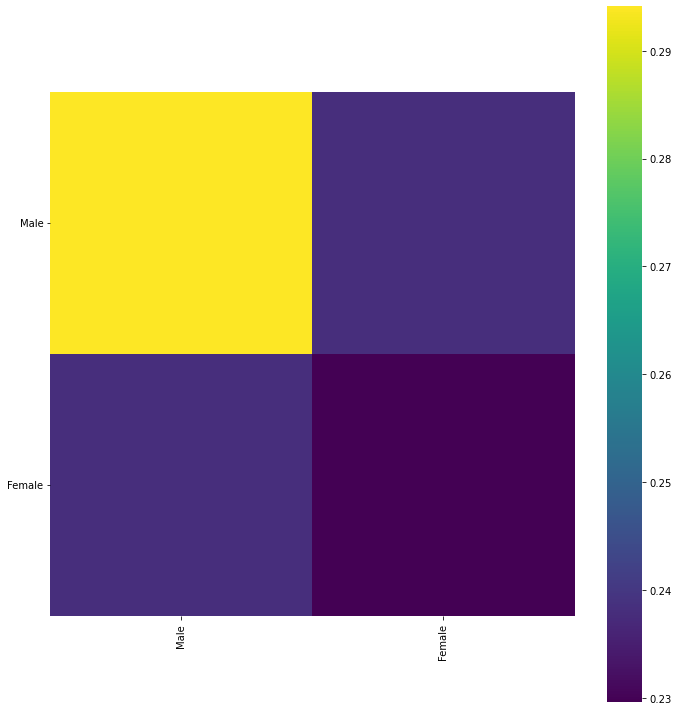

In [326]:
AM_sex = nx.attribute_mixing_matrix(G, 'sex')

sex_values = {
    1: 0, # female
    2: 1  # male
}

fig = plt.figure(figsize=(10, 10))
hmap = sns.heatmap(
    AM_sex,
    cbar=True,
    cmap='viridis',
    square=True)
hmap.set_xticklabels(['Male', 'Female'], rotation=90)
hmap.set_yticklabels(['Male', 'Female'], rotation=0)
plt.tight_layout()
plt.savefig('AM_uni.png', transparent=True, dpi=150)

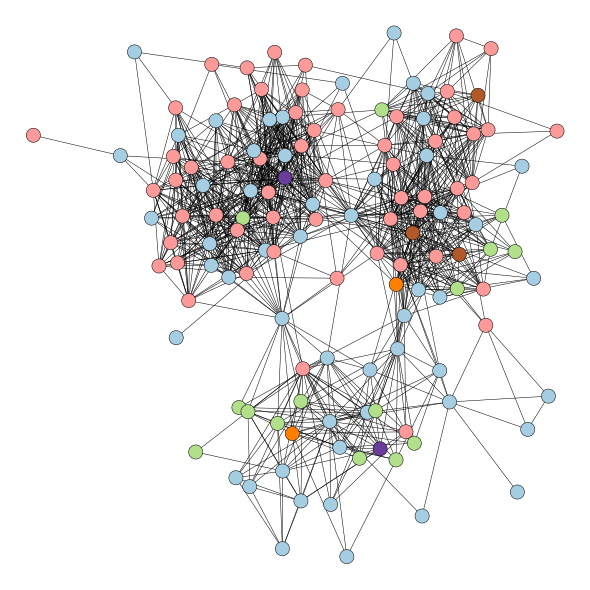

In [329]:
node_uni = list(nx.get_node_attributes(G, 'uni_code').values())

plt.figure(figsize=(8, 8))
nx.draw(G, 
        pos,
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.Paired,
        node_size=200,
        #labels=nx.get_node_attributes(G, 'uni_clean'),
        node_color=node_uni)

plt.savefig('university.png', transparent=True, dpi=150)

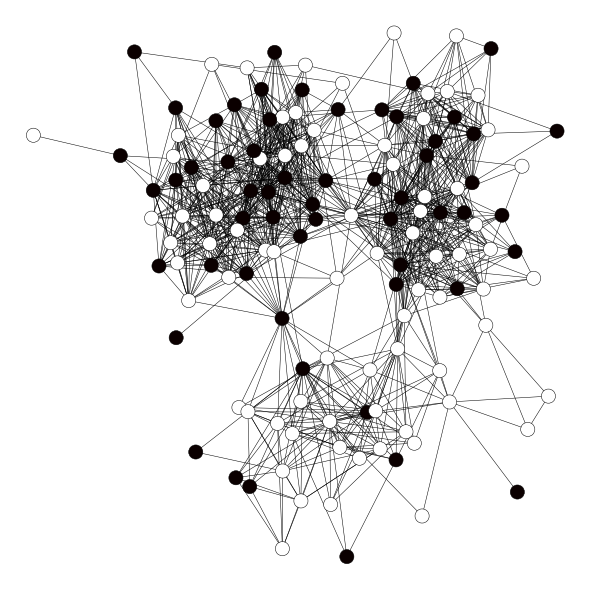

In [276]:
node_sex = list(nx.get_node_attributes(G, 'sex').values())
node_sex = [1-i for i in node_sex]

plt.figure(figsize=(8, 8))
nx.draw(G, 
        pos,
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.hot,
        node_size=200,
        node_color=node_sex)

plt.savefig('sex.png', transparent=True, dpi=150)